# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros&cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q2 - 30 points - Item similarity
- Q3 - 40 points - Content based recommendation  
- Q4 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [1]:
# !pip install --quiet zipfile36
# !pip install wordcloud

**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [5]:
random.seed(123)

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation.  
Explore at least 3 features, one of the features should be text (e.g. movie title). 

Use plots and discuss your insights and possible challenges related to the dataset.


In [6]:
# Download movie dataset
import time
import random
import zipfile
import requests
import warnings

url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'
r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)
with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [8]:
#Creating dataframe tables
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

In [9]:
# User table
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
# Item table
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.head()
# df_items.shape

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


##### Cleaning Data

In [11]:
# # Drop movie without release data
# df_items = df_items[~df_items['release_date'].isna()] 

# Drop movies without any genres (genre vector = 0)
genres = ['Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

# no_genres = df_items[genres].sum(axis = 1)
# no_genres[no_genres == 0].index
# df_items = df_items.drop(no_genres[no_genres == 0].index)

df_items.shape

(1682, 24)

In [13]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


##### Data Exploration

In [14]:
a = df_items[genres].sum()
top_genres = a.nlargest(5).index
top_genres

Index(['Drama', 'Comedy', 'Action', 'Thriller', 'Romance'], dtype='object')

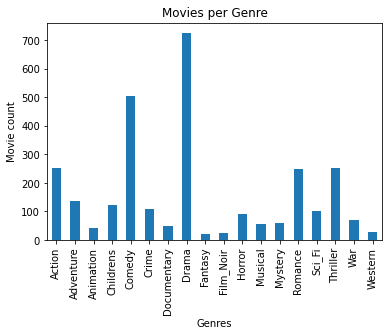

In [15]:
plt.figure()
ax = a.plot(kind='bar')
ax.set_title('Movies per Genre')
ax.set_xlabel('Genres')
ax.set_ylabel('Movie count')
ax.set_xticklabels(genres)
plt.show()

Based on table above, there are significantly more drama movies than any other movies. 

In [16]:
# Genreate numeric month feature
from calendar import month_abbr

def extract_release_month(row):
  try:
    return row.split("-")[1]
  except:
    print(row)

df_items_new = df_items[~df_items['release_date'].isna()] 

df_items_new['release_month'] = df_items_new['release_date'].astype(str).apply(extract_release_month)
lower_ma = [m.lower() for m in month_abbr]
df_items_new['month'] = df_items_new['release_month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')
df_items_new.head()

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,release_month,month
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Jan,1
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Jan,1
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Jan,1
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,Jan,1
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,Jan,1


We added one month feature to the data and that is release month

In [17]:
genres_per_month = pd.DataFrame(data = df_items_new.groupby(['month'])[genres].sum(), columns = genres, index = df_items_new.groupby(['month'])[genres].sum().index )
genres_per_month

,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
month,,,,,,,,,,,,,,,,,,
1,172,93,30,88,341,67,27,483,14,21,78,43,43,171,75,167,56,25
2,11,3,0,3,24,8,5,24,1,1,2,2,7,12,2,17,1,0
3,14,4,4,6,21,4,5,34,0,0,2,3,2,11,4,13,5,0
4,5,2,4,1,20,3,2,24,0,1,4,2,1,8,2,11,4,0
5,11,7,0,4,16,5,1,24,2,0,0,0,3,7,4,7,0,1
6,6,6,2,3,14,5,1,22,1,0,0,2,2,13,3,7,0,0
7,5,5,0,5,17,0,0,9,2,0,2,1,0,1,4,2,1,0
8,12,6,0,5,16,6,0,16,0,1,0,0,1,6,5,10,0,0
9,7,4,0,3,6,5,3,18,1,0,0,1,0,3,0,5,0,1


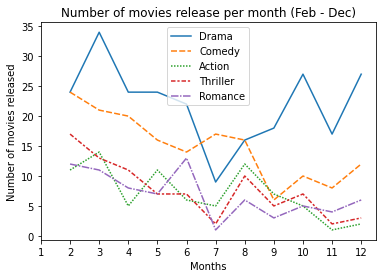

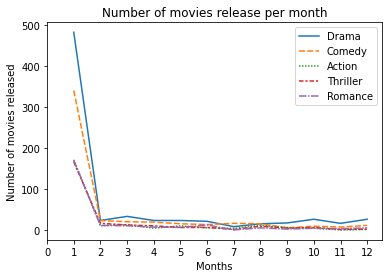

In [18]:
#Since Jan count is significantly higher than the rest we split it up into 2 graphs
sns.lineplot(data = genres_per_month[top_genres][1:] )
plt.title('Number of movies release per month (Feb - Dec)')
plt.xlabel('Months')
plt.ylabel('Number of movies released')
plt.xticks([i for i in range(1,13)])
plt.show()

sns.lineplot(data = genres_per_month[top_genres])
plt.title('Number of movies release per month')
plt.xlabel('Months')
plt.ylabel('Number of movies released')
plt.xticks([i for i in range(13)])
plt.show()

In [19]:
genres_no_drama = genres.copy()
genres_no_drama.remove('Drama')
drama = df_items[df_items['Drama'] == 1][genres_no_drama].sum(axis = 0)

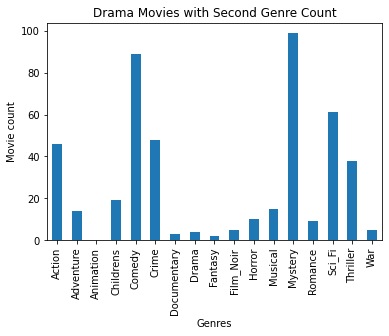

In [20]:
ax = drama.plot(kind='bar')
ax.set_title('Drama Movies with Second Genre Count')
ax.set_xlabel('Genres')
ax.set_ylabel('Movie count')
ax.set_xticklabels(genres)
plt.show()

All drama movies also have a second category. Distribution of second category for drama movies can be seen in plot above. 

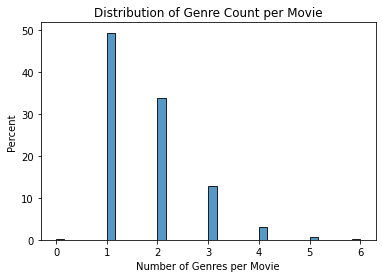

In [21]:
sns.histplot(df_items[genres].sum(axis = 1)[1:],stat ='percent')
plt.title('Distribution of Genre Count per Movie')
plt.xlabel('Number of Genres per Movie')
plt.show()

In bar graph above, this is the distribution of unmber of genre per movie. Close to 50% have a single genre and 33% have 2 genres. 

**Text Exploration**

One of the popular tools for text data exploration is word cloud. Other options may include word distribution. 

Add a plots for your analysis and describe your insights. 

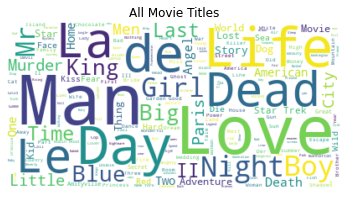

In [22]:
text = list(df_items.movie_title)
text = ' '.join(text)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'All Movie Titles')
plt.show()

From all the movies, most common words include: Love, Man, Day, Life.

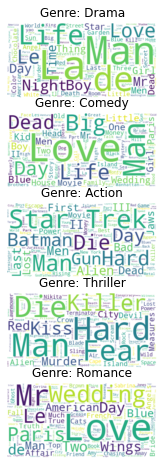

In [23]:
fig, ax = plt.subplots(5, 1, figsize = (15,8))
for i in range(5):
  text = list(df_items[df_items[top_genres[i]] == 1].movie_title)
  text = ' '.join(text)
  wordcloud = WordCloud(background_color="white").generate(text)
  ax[i].imshow(wordcloud, interpolation="bilinear")
  ax[i].axis("off")
  ax[i].set_xlabel('f''Genres: {top_genres[i]}')
  ax[i].set_title(f'Genre: {top_genres[i]}')

plt.show()

Above plots shows the frequency of movie title words across different genres. 

<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please answer, code, and explain your answer.  
In case you don't have a clear answer, please mention your hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features. Discuss the contribution of each feature
Tip: When looking on the MovieLens dataset it's features vector will include `genres`, `title`, etc.

We decided to use all the genres as features and for each word in the movie titles create another feature with the TFIDF score as the values

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
# preprocess - clean the movie titles from years
def preprocess(string):
  return string.split('(19')[0]

df_items['movie_title'] = df_items['movie_title'].apply(preprocess)

In [27]:
def generate_movie_profile(df_items):
  vectorizer = TfidfVectorizer(analyzer='word', stop_words='english') 
  vectors = vectorizer.fit_transform(df_items['movie_title']).toarray()
  feature_names = vectorizer.get_feature_names()

  movie_profile = df_items[['movie id']+ genres]
  for i,word in enumerate(feature_names):
    movie_profile[word] = vectors[:,i]
  movie_profile.head()
  return movie_profile

movie_profile = generate_movie_profile(df_items)
movie_profile.head()

,movie id,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,000,100,101,12,13,1600,187,1992,20,2000,2001,3000,33,34th,37th,39,42nd,45,80,900,98,...,wives,wizard,wolf,wolves,woman,women,wonderful,wonderland,wong,wonka,wood,wooden,world,worrying,worst,wrath,wrong,wu,wyatt,wyn,xinghua,xiong,xue,yankee,yao,year,years,yeller,yellow,yes,yo,york,young,yue,zaproszenie,zeus,zoe,zone,zorro,zulu
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build a function which provides the 5 most similar items to a specific item. 
Please use `Cosine Similarity` metric to calculate Item to item similarity.


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
def get_similar_items(movie_profiles,item_id,n=5): # you can add no_self=True for debbuging
    #Using implicit index of DF
    index = int(movie_profile[movie_profile['movie id'] == item_id].index.values)
    movie_similarity = pd.DataFrame(cosine_similarity(movie_profile)) 
    most_similar_items = movie_similarity.iloc[index].nlargest(n+1).to_frame()
    movie_ids = pd.Series([int(movie_profile.iloc[similar_index]['movie id']) for similar_index in most_similar_items.index ], index = most_similar_items.index )
    most_similar_items['movie id'] = movie_ids
    return most_similar_items

In [30]:
import urllib

pics = pd.read_csv('https://raw.githubusercontent.com/ShopRunner/collie/main/data/movielens_posters.csv',delimiter=',').set_index('item_id')
pics.loc[72] = 'https://m.media-amazon.com/images/I/71-NkSYGuSL._SL1384_.jpg'
def add_pics(items, size = (12,6)):
    fig, ax = plt.subplots(1, len(items), figsize = size)
    for i, item in enumerate(items):
        ax[i].axis('off')
        ax[i].imshow(plt.imread(urllib.request.urlopen(pics.url.loc[item]), 0))
    fig.tight_layout()

### Use the above function to find the 5 most similar items for 2 items from the dataset. 
Please discuss the results you got. Are there any challenges? 

Please add the movie's title and image to your explanation.  (see example)

In [31]:
# first item
item_id = 95
result = get_similar_items(movie_profile, item_id)
columns = ['movie_title', 'movie id'] + genres
movie_ids = result['movie id'].values
items = df_items[df_items['movie id'].isin(movie_ids)][columns]
final_result = result.merge(items, on = 'movie id')
final_result.set_index('movie id', inplace = True)
final_result.columns = ['cosine_similarity_score', 'movie_title'] + genres
final_result

,cosine_similarity_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,
95,1.000000,Aladdin,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
103,0.999841,All Dogs Go to Heaven 2,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
99,0.999838,Snow White and the Seven Dwarfs,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
91,0.999829,"Nightmare Before Christmas, The",0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
422,0.999802,Aladdin and the King of Thieves,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
139,0.999797,"Love Bug, The",0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


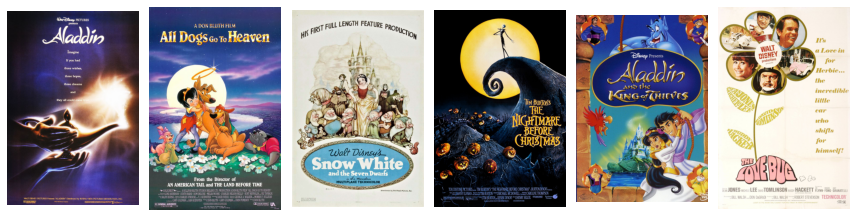

In [41]:
add_pics(list(final_result.index))

In [32]:
# second item
item_id = 94
result = get_similar_items(movie_profile, item_id)
columns = ['movie_title', 'movie id'] + genres
movie_ids = result['movie id'].values
items = df_items[df_items['movie id'].isin(movie_ids)][columns]
final_result = result.merge(items, on = 'movie id')
final_result.set_index('movie id', inplace = True)
final_result.columns = ['cosine_similarity_score', 'movie_title'] + genres
final_result

,cosine_similarity_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,
94,1.000000,Home Alone,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
139,0.999906,"Love Bug, The",0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
138,0.999906,D3: The Mighty Ducks,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
225,0.999895,101 Dalmatians,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
243,0.999892,Jungle2Jungle,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
259,0.999890,George of the Jungle,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


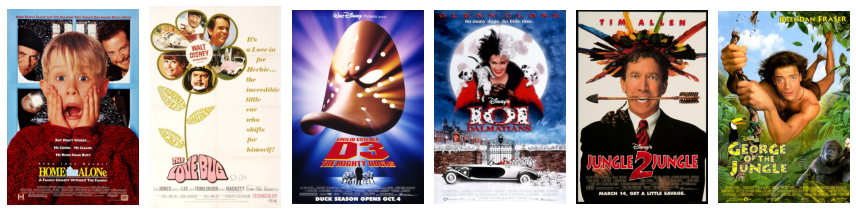

In [33]:
add_pics(list(final_result.index))

#### Challenges of method

1. There is no variance among users and does not take into account user ratings. 
2. Requires cosine vector to be similar which likely means its in similar genres. But sometimes recommendation per user can be varied by genres.
3. Data may be skewed and give higher weight and similarity to more common genres (ex: Drama)


<br><br><br><br><br><br>
# Question 3:
# Content based recommendation



### Build a function which recommends 5 most relevant items to a user. 

In [34]:
#First change index of movie profile to have movie id as index
movie_profile_2 = movie_profile.set_index('movie id')

print(f'movie profile vector has length: {movie_profile_2.shape[1]}')
print(f'movie profile DF includes: {movie_profile_2.shape[0]} movies')

movie profile vector has length: 2239
movie profile DF includes: 1682 movies


In [35]:
def generate_user_profile(user_ratings_train, movie_profile):
    # user profile
    user_ratings_train.sort_index(axis=0, inplace=True)
    userIDs = user_ratings_train.columns
    user_profile = pd.DataFrame(columns = movie_profile.columns)

    #user_ratings_train rows are items, columns are users
    for user in user_ratings_train.columns:
      working_df = movie_profile.mul(user_ratings_train.loc[:,user], axis = 0)
      num_movies_rated_by_user = working_df.loc[(working_df != 0).any(axis=1)].shape[0]
      user_profile.loc[user] = working_df.sum(axis = 0) / num_movies_rated_by_user      # working_df.mean(axis=0)
    return user_profile

def get_item_recommendations(users_profile,movies_profile,user_id,n=5, show_title=False, only_rated= None):
    movie_similarity = pd.DataFrame(cosine_similarity(users_profile, movies_profile), index = users_profile.index, columns = movies_profile.index ) 
    if only_rated is not None:
      #Only give prediction for user that user has already given rating
      most_similar_items = movie_similarity.loc[user_id,only_rated[only_rated.loc[:,user_id] > 0].loc[:,user_id].index].nlargest(n).to_frame()
    else:
      most_similar_items = movie_similarity.loc[user_id].nlargest(n).to_frame()
    most_similar_items.columns.name = 'movie id'
    if not show_title:
      return most_similar_items
    else:
      movie_ids = most_similar_items.index
      items = df_items[df_items['movie id'].isin(movie_ids)][['movie id','movie_title']]
      items.set_index('movie id', inplace = True)
      final_result = pd.concat([most_similar_items, items], axis = 1)
      return final_result


def generate_ratings(ratings, user_profile, movie_profile, n):
    prediction = pd.DataFrame(np.zeros(shape=(len(ratings.index),len(ratings.columns))), index = ratings.index, columns = ratings.columns)
    for i , user_id in enumerate(ratings.columns):
        recommendations = get_item_recommendations(user_profile,movie_profile,user_id,n, only_rated = ratings)
        for movie_id in recommendations.index:
          if movie_id not in prediction.index:
            continue
          else:
            #Give rating of 5 for top 5 recommendations
            prediction.loc[movie_id, user_id] = 5
    return prediction

In [38]:
movie_profile_2.head()

,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,000,100,101,12,13,1600,187,1992,20,2000,2001,3000,33,34th,37th,39,42nd,45,80,900,98,aardman,...,wives,wizard,wolf,wolves,woman,women,wonderful,wonderland,wong,wonka,wood,wooden,world,worrying,worst,wrath,wrong,wu,wyatt,wyn,xinghua,xiong,xue,yankee,yao,year,years,yeller,yellow,yes,yo,york,young,yue,zaproszenie,zeus,zoe,zone,zorro,zulu
movie id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test your recommender system on 2 users. Explain your results.

In [39]:
#Using all data
ratings = pd.pivot_table(df_ratings, values='rating', index=['item_id'], columns = ['user_id'])
ratings.replace(np.NaN,0, inplace=True) 
ratings.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,1.0,5.0,4.0,5.0,0.0,3.0,5.0,0.0,5.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,4.0,3.0,3.0,4.0,0.0,3.0,5.0,3.0,5.0,0.0,0.0,5.0,0.0,3.0,3.0,0.0,4.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,5.0,0.0,0.0,5.0,0.0,3.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# First generate user profile for all users
user_profile = generate_user_profile(ratings, movie_profile_2)
user_profile.head()

,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,000,100,101,12,13,1600,187,1992,20,2000,2001,3000,33,34th,37th,39,42nd,45,80,900,98,aardman,...,wives,wizard,wolf,wolves,woman,women,wonderful,wonderland,wong,wonka,wood,wooden,world,worrying,worst,wrath,wrong,wu,wyatt,wyn,xinghua,xiong,xue,yankee,yao,year,years,yeller,yellow,yes,yo,york,young,yue,zaproszenie,zeus,zoe,zone,zorro,zulu
1,0.919118,0.452206,0.147059,0.202206,1.161765,0.316176,0.088235,1.544118,0.025735,0.018382,0.165441,0.139706,0.066176,0.636029,0.632353,0.691176,0.338235,0.080882,0.005754,0.0,0.005199,0.011383,0.010399,0.000000,0.000000,0.000000,0.005754,0.000000,0.008744,0.008687,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00841,...,0.0,0.010399,0.0,0.007799,0.008904,0.0,0.0,0.000000,0.004933,0.007800,0.018774,0.0,0.010350,0.0,0.0,0.010283,0.012644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014739,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.02046,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.612903,0.209677,0.064516,0.193548,0.983871,0.548387,0.000000,2.161290,0.048387,0.145161,0.096774,0.048387,0.225806,1.064516,0.241935,0.693548,0.177419,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.722222,0.259259,0.000000,0.000000,0.574074,0.555556,0.092593,1.185185,0.000000,0.092593,0.222222,0.074074,0.648148,0.314815,0.407407,0.981481,0.259259,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.043264,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.023234,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.014193,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.291667,0.583333,0.000000,0.000000,0.833333,0.791667,0.208333,1.125000,0.000000,0.000000,0.166667,0.208333,0.833333,0.541667,0.958333,1.791667,0.375000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130355,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.005714,0.611429,0.302857,0.405714,1.405714,0.200000,0.000000,0.411429,0.028571,0.028571,0.405714,0.228571,0.051429,0.251429,0.662857,0.320000,0.257143,0.028571,0.000000,0.0,0.008081,0.000000,0.000000,0.000000,0.000000,0.003823,0.000000,0.000000,0.013590,0.013502,0.007972,0.003429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.011791,0.010222,0.009093,0.000000,0.0,0.000000,0.0,0.0,0.015982,0.019652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011877,0.0,0.00438,0.0,0.000000,0.0,0.0,0.01590,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,20,movie_title
movie id,,
21,0.666792,Muppet Treasure Island
172,0.740376,"Empire Strikes Back, The"
252,0.688868,"Lost World: Jurassic Park, The"
720,0.670764,First Knight
1025,0.719261,Fire Down Below


[]

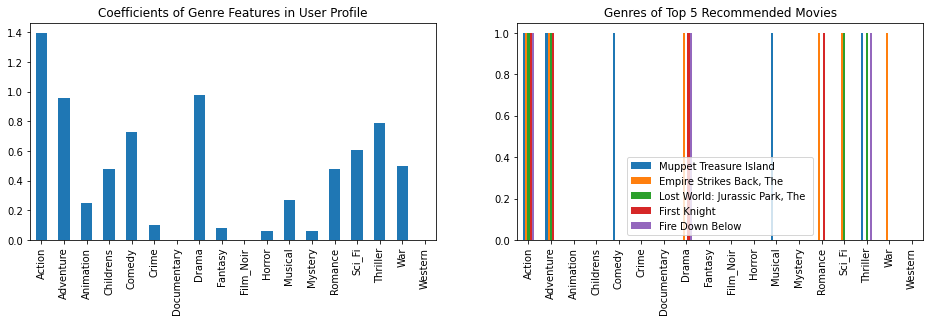

In [41]:
# Get recommendation for specific user
user_id = 20
result = get_item_recommendations(user_profile,movie_profile_2, user_id, show_title=True)
display(result)

fig, axes = plt.subplots(1,2, figsize=(16,4))  
user_profile.loc[user_id][genres].plot(kind='bar',ax=axes[0]);  
axes[0].set_title('Coefficients of Genre Features in User Profile')
movie_profile_2.loc[result.index][genres].T.plot(kind='bar',ax=axes[1]) 
axes[1].set_title('Genres of Top 5 Recommended Movies')
plt.legend(result.movie_title)
plt.plot()

,100,movie_title
movie id,,
28,0.739187,Apollo 13
54,0.739187,Outbreak
244,0.739187,Smilla's Sense of Snow
917,0.739187,Mercury Rising
1025,0.853539,Fire Down Below


[]

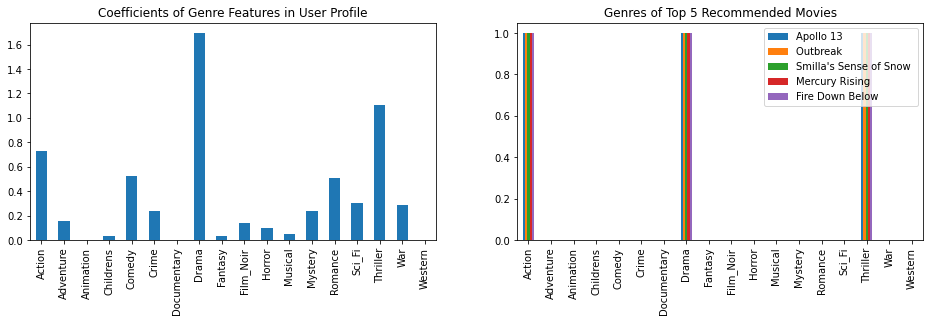

In [42]:
user_id = 100
result = get_item_recommendations(user_profile,movie_profile_2, user_id, show_title=True)
display(result)

fig, axes = plt.subplots(1,2, figsize=(16,4))  
user_profile.loc[user_id][genres].plot(kind='bar',ax=axes[0]);  
axes[0].set_title('Coefficients of Genre Features in User Profile')
movie_profile_2.loc[result.index][genres].T.plot(kind='bar',ax=axes[1])  
axes[1].set_title('Genres of Top 5 Recommended Movies')
plt.legend(result.movie_title)
plt.plot()

The top 5 movie recommendation result genres seems very correlated to the user preference genres. For user 100 we see that his top genres are Drama, Action, Thriller and we can see that the only genres included in his top 5 movies are from those 3 genres.

### Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

In [43]:
# Split data to train and test
#Using the full dataset
df_train = pd.read_csv(data_dir + 'u2.base',delimiter='\t', header=None,names=cols_data)
df_test = pd.read_csv(data_dir + 'u2.test',delimiter='\t', header=None,names=cols_data)

# Make note that index has changed to movie id
user_ratings_train = pd.pivot_table(df_train, values='rating', index=['item_id'], columns = ['user_id'])
user_ratings_test = pd.pivot_table(df_test, values='rating', index=['item_id'], columns = ['user_id'])
user_ratings_train.replace(np.NaN,0, inplace=True) 
user_ratings_test.replace(np.NaN,0, inplace=True) 
user_ratings_train.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,5.0,0.0,3.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,4.0,3.0,3.0,4.0,0.0,3.0,5.0,3.0,5.0,0.0,0.0,5.0,0.0,3.0,3.0,0.0,4.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#First generate user profile for all users
s = time.time()
user_profile_train = generate_user_profile(user_ratings_train, movie_profile_2)
cb_train_time = time.time() - s
print(f'Content based model training time: {np.round(cb_train_time,2)} s')

Content based model training time: 112.98 s


In [45]:
def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5,threshold=3):
    user_true = user_true[user_true > 0]
    user_pred = user_pred.loc[user_true.index]
    user_pred = user_pred.reset_index(drop=True).nlargest(top_n)

    if user_pred.size == 0: 
        return 0
    if user_pred.nlargest(1).values[0] < threshold: 
        return 0
    user_pred = user_pred[user_pred > 0]
    user_true = user_true.reset_index(drop=True).loc[user_pred.index]
    if user_true.nlargest(1).values[0] < threshold:
        return 0
    indexes = user_pred.isin(user_pred.loc[user_true.nlargest(1).index])
    return 1 / (indexes.reset_index(drop=True).nlargest(1).index[0] + 1)    

def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,threshold=3,MF = False):
    # please use MRR_for_user
    rank_sum = 0
    not_rated_users = 0
    users = df_true.shape[1]
    if MF: 
        df_pred[df_pred > upper_bound] = upper_bound
        df_pred[df_pred < lower_bound] = lower_bound

        for i in df_true.index: 
          if i in df_pred.index:
            rank = MRR_for_user(df_true.loc[i,:],df_pred.loc[i,:],lower_bound,upper_bound,top_n,threshold)
            rank_sum += rank
    else:
        for i in df_true.columns: 

          rank = MRR_for_user(df_true.loc[:,i],df_pred.loc[:,i],lower_bound,upper_bound,top_n,threshold)

          rank_sum += rank
    if users == not_rated_users:
        return 0

    return rank_sum / (users - not_rated_users)

In [46]:
#Generating ratings for test data
s = time.time()
#Only give rating to movies that have rating in test data so can compare to ground truth
prediction = generate_ratings(user_ratings_test, user_profile_train, movie_profile_2, n=5)
cb_inf_time = time.time() - s
print(f'Content based model inference time: {np.round(cb_inf_time,2)} s')

Content based model inference time: 189.31 s


In [47]:
CB_MRR = MRR(user_ratings_test,prediction)
print(f'MRR metric for n = 5: {CB_MRR}')

MRR metric for n = 5: 0.9923430321592649


<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams)

Compare the results you got using the different methods. Discuss your findings

In [48]:
# MF class
class MF():
    
    def __init__(self,df_train,movies, users, n_factors=10,only_bias=False):
        self.df_train = df_train.astype(float)
        self.n_factors = n_factors #Latent vectors
        self.only_bias = only_bias 
        self.recommended = df_train.copy()
        self.recommended[:] = 0
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        

        self.movies = movies
        self.users = users    

        self.train_rating = [(i, j, self.df_train[i, j]) for i in range(self.n_rows)
                          for j in range(self.n_cols)
                          if self.df_train[i, j] > 0 ] #Indexes of user/item - remove any user/items with no ratings at all

        # biases
        self.original_bias_global = np.sum(df_train)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)
        
        # Add weight matrices to learn encoded factor matrix
        self.user_vecs = np.random.standard_normal((self.n_rows,self.n_factors))
        self.item_vecs = np.random.standard_normal((self.n_cols,self.n_factors))

        # "reset" initialization 
        self.initilize_params()

        
    def initilize_params(self):
        if self.only_bias:
            self.user_vecs = np.zeros((self.n_rows, self.n_factors))
            self.item_vecs = np.zeros((self.n_cols, self.n_factors))

        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = np.random.standard_normal(self.n_rows) # random 
        self.bias_cols   =  np.random.standard_normal(self.n_cols) # random 
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
        
        if initilize_training:
            self.initilize_params()

        # please record your progress in history
        self.history = []
        
        # please record the training time in fit_time
        self.fit_time = None
        start = time.time()
        
        # please use the class functions 
        # for example(!) :
        for current_iteration in range(self.n_iterations):
            self.history.append(self.get_rmse(self.df_train))
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            # convergence
            if current_iteration!=0 and self.converging():
                if verbose:
                    print('converged...')
                break         
            self.optim_GD(current_iteration)
            
        self.recommended = pd.DataFrame(self.predict(), index = self.users, columns = self.movies) 
        self.fit_time = time.time() - start
 
    def converging(self):
        delta = np.abs(self.history[-1] - self.history[-2])
        return delta < self.ϵ
    
                  
    def optim_GD(self,t):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        for i,j,r in self.train_rating:
            e = r - self.predict_single(i,j)
            #Update bias
            self.bias_rows[i] = self.bias_rows[i] + (self.α)*(e - self.λ * self.bias_rows[i])
            self.bias_cols[j] = self.bias_cols[j] + (self.α)*(e - self.λ * self.bias_cols[j])
       
            #Update latent factor weights    
            user_vecs_temp = self.user_vecs[i].copy() 
            self.user_vecs[i] = self.user_vecs[i] + (self.α) * (e * self.item_vecs[j] - self.λ * self.user_vecs[i])
            self.item_vecs[j] = self.item_vecs[j] + (self.α) * (e * user_vecs_temp  - self.λ * self.item_vecs[j])   
            
            
    def predict_single(self, u ,i):
        #For user id = u and item id = i
        return np.nan_to_num(self.original_bias_global + self.bias_rows[u] + self.bias_cols[i] + self.user_vecs[u].dot(self.item_vecs[i].T))
    
    def predict(self,N=10):
        output = np.nan_to_num(self.original_bias_global + self.bias_rows[:, np.newaxis] + self.bias_cols[np.newaxis,:] + self.user_vecs.dot(self.item_vecs.T))
        return output
           
    def RMSE(self, df_true,df_pred,lower_bound=1,upper_bound=5):
        # if type(df_pred) != type(np.array([1])):
        #     df_pred = df_pred.values
        # if type(df_true) != type(np.array([1])):
        #     df_true = df_true.values
        non_zeros = df_true != 0 
        # print(df_true.shape)
        # print(df_pred.shape)
        mse = np.power(((df_true - df_pred) * non_zeros),2)
        return np.sqrt(mse.sum()/ non_zeros.sum())
      
    def get_rmse(self,test):
        # please use my_metrics
        pred =  self.predict()
        return self.RMSE(test, pred)

    def get_mrr(self,test,k=10,threshold=3):
        # Please use my_metrics
        return MRR(test, self.recommended, top_n=k, threshold=threshold,MF = True)

In [49]:
def get_item2vec(mf,i):
    #Get item i vector
    return mf.item_vecs[i]   


In [50]:
#initialize model
model_mf = MF(ratings.T.values , movies = ratings.index,users = ratings.columns ,n_factors=5,only_bias=False)

# train model with best hyperparameters found in assignment 1
model_mf.fit(n_iterations=20,verbose=False,regularization=0.1,convergence=0.00100,learning_rate=0.01)


In [51]:
#Get item cosine similarity matrix
cosine_sim_movies = pd.DataFrame(cosine_similarity(model_mf.item_vecs))
cosine_sim_movies.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,1.000000,0.611675,-0.465725,-0.371527,0.610450,0.153097,0.622946,0.341981,-0.445855,0.147942,0.383328,-0.013537,-0.205264,-0.634697,-0.163148,0.484894,0.297020,-0.274281,0.553497,0.144194,0.129319,-0.306126,-0.035031,0.239622,-0.524058,-0.340136,-0.285047,-0.004274,0.068297,0.701753,-0.150536,0.034348,-0.210864,0.377744,0.515538,0.272775,0.282336,0.478902,0.663228,0.762938,...,0.151978,-0.463371,0.404396,0.112644,0.093163,-0.004403,-0.055854,-0.966214,0.039116,0.416169,-0.510874,0.703696,-0.077370,0.104028,0.505971,0.170934,-0.214261,-0.131430,0.629659,-0.055206,-0.235086,0.094368,0.683933,-0.403715,-0.469222,0.061402,-0.353396,0.570621,-0.545953,0.195690,0.198770,-0.101582,0.540537,0.720991,0.246111,0.310867,-0.182468,-0.266556,0.609229,0.027680
1,0.611675,1.000000,-0.414081,-0.036845,0.856729,0.210648,-0.208922,0.448588,-0.374267,0.520931,0.027972,-0.256858,-0.071116,-0.377053,-0.161623,0.103424,-0.417929,-0.370496,-0.069096,-0.518980,0.067059,0.070465,-0.583933,0.279022,0.133385,0.235702,0.280423,0.149244,-0.248726,0.477811,0.140612,-0.409413,-0.575717,0.582344,0.549018,0.442412,0.215397,0.488320,0.305582,0.396311,...,-0.491170,-0.184763,-0.219723,0.433862,-0.613712,0.524514,0.704464,-0.567689,-0.625501,0.739990,-0.485286,0.745135,0.231962,0.575286,0.903843,-0.651567,0.374810,-0.031474,0.228501,0.133571,-0.281305,0.512894,0.008101,-0.596112,-0.347176,-0.119420,-0.142668,0.942493,-0.904455,0.053190,0.475127,-0.714828,0.390295,0.796029,0.491466,-0.122844,-0.552882,-0.014590,0.051179,0.279887
2,-0.465725,-0.414081,1.000000,0.040565,-0.185780,-0.086121,-0.225161,-0.765888,-0.160818,0.245204,-0.357670,0.122111,0.019078,-0.209117,0.345703,0.398029,-0.111329,0.238407,-0.068920,-0.194146,0.283044,0.359811,-0.076771,-0.159243,0.523338,-0.466470,0.062278,0.294476,0.636818,-0.014054,0.474291,-0.093649,0.333140,-0.654614,0.293810,-0.140346,-0.475212,0.289068,0.069242,-0.178816,...,0.516882,0.794012,-0.692680,-0.311662,0.262891,-0.230060,-0.125825,0.410782,-0.074234,0.045211,0.569914,-0.616492,-0.469560,0.376437,-0.709945,0.106381,0.258248,-0.233186,0.070439,0.703393,0.519788,-0.698337,0.179636,0.551733,0.747786,0.318759,-0.521511,-0.157061,0.501751,-0.458855,0.053316,0.318056,-0.100364,-0.256448,-0.595221,0.659698,0.230307,-0.678091,-0.537390,-0.776658
3,-0.371527,-0.036845,0.040565,1.000000,-0.458936,0.627103,-0.233558,-0.107094,0.849969,0.608783,-0.085125,0.743416,0.959354,0.527353,-0.806986,-0.199306,-0.786279,0.655904,-0.703199,-0.057178,-0.855476,-0.493081,0.428132,0.669259,0.415010,0.717044,-0.374215,-0.601727,-0.651963,0.010412,-0.607527,0.512416,-0.455245,0.560527,-0.059036,0.415800,0.716728,-0.575723,-0.297516,-0.272166,...,-0.077004,0.001169,-0.262934,-0.012381,0.013114,-0.396122,-0.033784,0.338099,-0.317115,-0.337868,0.519889,-0.233991,-0.511462,0.367364,0.016064,-0.318258,0.792977,-0.646256,0.150589,-0.469654,-0.756301,-0.146678,-0.274314,-0.315389,0.452308,-0.500215,-0.203909,0.086514,0.152041,-0.322602,-0.620951,-0.533983,-0.890549,-0.222267,-0.493573,-0.207214,-0.777035,0.167992,-0.349679,-0.250221
4,0.610450,0.856729,-0.185780,-0.458936,1.000000,-0.239694,-0.141090,0.176690,-0.720163,0.226364,0.150060,-0.508022,-0.457046,-0.704564,0.245492,0.351660,-0.091536,-0.460255,0.107994,-0.623832,0.435074,0.289764,-0.720448,0.030723,-0.019973,-0.170423,0.390068,0.348368,0.250064,0.312815,0.551461,-0.557316,-0.130132,0.206447,0.675657,0.349965,-0.192361,0.691703,0.538159,0.303415,...,-0.271267,0.116480,-0.270266,0.525145,-0.617373,0.701172,0.627388,-0.618516,-0.575299,0.938637,-0.678973,0.764719,0.326039,0.400171,0.710692,-0.413304,0.086557,0.302727,0.215546,0.516229,0.199499,0.334060,0.156637,-0.163698,-0.464098,0.0082

In [52]:
#Item id = 93 --> movie id = 94
data = cosine_sim_movies[93].nlargest(6)
#print item title 
movie_ids = data.index + 1

pd.concat([ data, df_items[df_items['movie id'].isin(movie_ids)]['movie_title'],], axis = 1)


,93,movie_title
93,1.000000,Home Alone
232,0.926601,Under Siege
728,0.930659,Nell
767,0.941765,Casper
1017,0.962568,Tie Me Up! Tie Me Down!
1446,0.950485,Century


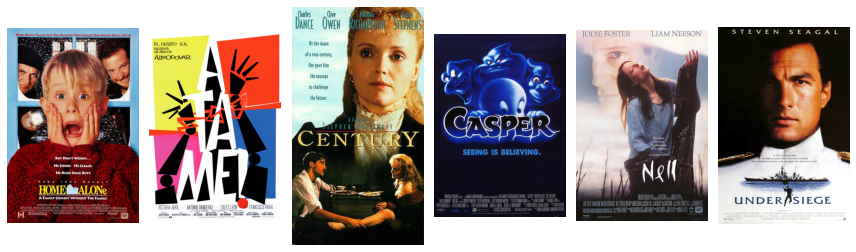

In [53]:
add_pics(list(movie_ids))

In [54]:
#Item id = 94 -> movie id = 95
data = cosine_sim_movies[94].nlargest(6)
movie_ids = data.index + 1

pd.concat([ data, df_items[df_items['movie id'].isin(movie_ids)]['movie_title'],], axis = 1)


,94,movie_title
94,1.000000,Aladdin
229,0.981234,Star Trek IV: The Voyage Home
1072,0.985083,Shallow Grave
1378,0.974699,Love and Other Catastrophes
1394,0.986483,Hurricane Streets
1430,0.960766,Legal Deceit


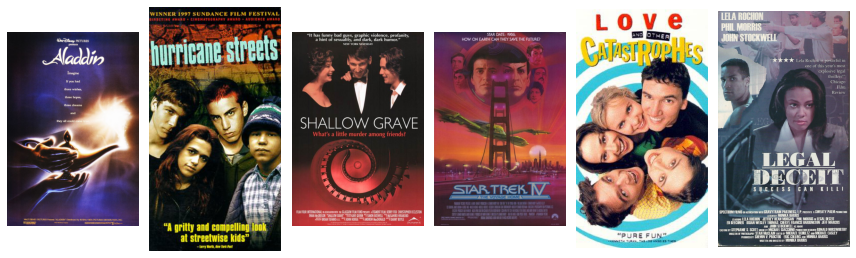

In [55]:
add_pics(list(movie_ids))

We can see that cosine similarity of latent vector is very weak. Its not returning similar results.

### Use MF implementation for item recommendations 

Use the matrix factorization implemention from exercise 1 to recommend 5 items to **the same 2 users** you used above. 
(Use your optimal hyperparams)

Compare the results you got using the different methods. Discuss your findings

In [56]:
#Run mf and find top 5
# function using the MF class 
def get_MF_similar_items_per_user(model, user_id, n = 5):
    recomend = pd.DataFrame(model.recommended)
    return recomend.iloc[user_id-1].nlargest(n)


In [57]:
# find similar items to the same two items you choose
#id = 19 --> user_Id = 20
movie_ids = get_MF_similar_items_per_user(model_mf, 19, n = 5).index + 1

df_items[df_items['movie id'].isin(movie_ids)]['movie_title'], movie_ids

(1460            Here Comes Cookie 
 1616                    Hugo Pool 
 1621                Paris, France 
 1651    Temptress Moon (Feng Yue) 
 1671                         Kika 
 Name: movie_title, dtype: object,
 Int64Index([1652, 1622, 1617, 1461, 1672], dtype='int64', name='item_id'))

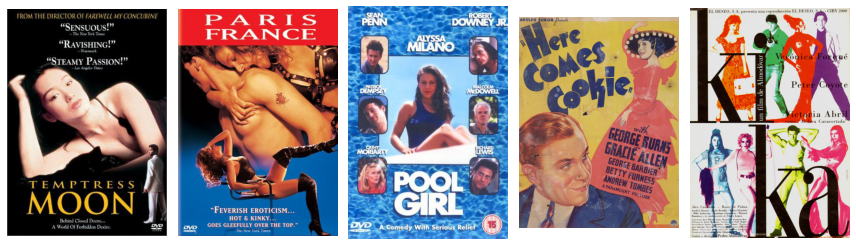

In [58]:
add_pics(list(movie_ids))

In [59]:
# find similar items to the same two items you choose
#id = 99 --> user_Id = 100
movie_ids = get_MF_similar_items_per_user(model_mf, 99, n = 5).index + 1

df_items[df_items['movie id'].isin(movie_ids)]['movie_title'], movie_ids

(626     Robin Hood: Prince of Thieves 
 1510       Children of the Revolution 
 1536                             Cosi 
 1619                   Sixth Man, The 
 1621                    Paris, France 
 Name: movie_title, dtype: object,
 Int64Index([1511, 1620, 1537, 1622, 627], dtype='int64', name='item_id'))

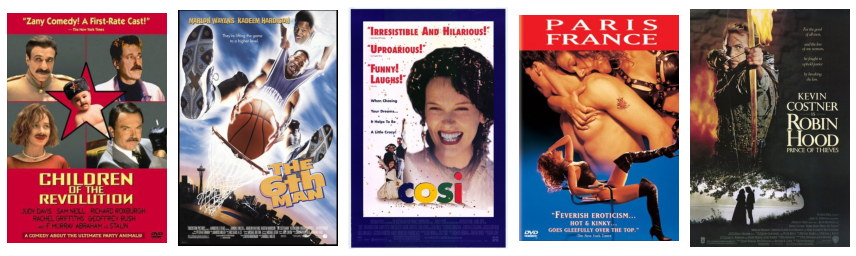

In [60]:
add_pics(list(movie_ids))

#### Interpretations:
Results between CB and MF recommendation per user are very different. This is likely due to the diferent user matrix that was used in each model. In CB we had more features to work with, seems to give us more accuracte results based on user preference.

### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (use plot). 

In [61]:
#initialize model with training data
import time
model_mf = MF(user_ratings_train.T.values , movies = user_ratings_train.index,users = user_ratings_train.columns ,n_factors=5,only_bias=False)

s = time.time()
# train model with best hyperparameters found in assignment 1
model_mf.fit(n_iterations=20,verbose=False,regularization=0.1,convergence=0.00100,learning_rate=0.01)
mf_train_end = time.time() - s
print(f'MF model training time: {np.round(mf_train_end, 2)} s')

MF model training time: 79.43 s


In [62]:
#Inference time 
import time
s = time.time()
model_mf.predict()
mf_inf_end = time.time() - s
print(f'MF model inference time: {np.round(mf_inf_end, 2)} s')

MF model inference time: 0.03 s


In [63]:
#get mrr metric on test data
MF_MRR = model_mf.get_mrr(user_ratings_test)
print(f'MRR metric for MF: {np.round(MF_MRR,2)}')

MRR metric for MF: 0.7


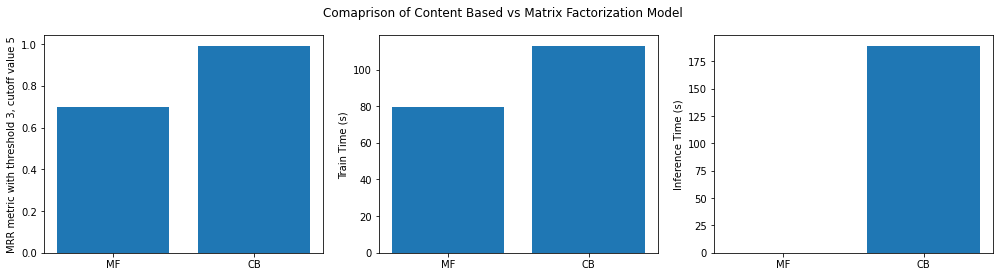

In [64]:
## Add plot with MRR for MF and CF 
mrr = {'MF': MF_MRR, 'CB': CB_MRR }
tt = {'MF': mf_train_end, 'CB': cb_train_time }
it = {'MF': mf_inf_end, 'CB': cb_inf_time }

keys = mrr.keys()
values = [mrr.values(), tt.values(),  it.values()]
titles = ['MRR metric with threshold 3, cutoff value 5', 'Train Time (s)', 'Inference Time (s)']

fig, ax = plt.subplots(1, 3, figsize = (17,4))

for i in range(3):
  ax[i].set_ylabel(titles[i])
  ax[i].bar(keys, values[i])

plt.suptitle('Comaprison of Content Based vs Matrix Factorization Model')
plt.show()

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
In your discussion please make sure to each of these rows and more...

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Dimentinality</td>
            <td style="text-align:center">Movie vector over 2000 features, each feature is a dimension</td>
            <td style="text-align:center">Movie vector size 5, size of latent factor </td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center">Based on item id vector</td>
            <td style="text-align:center">Without many item features, use user id to user id rating comparison</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center">Better in case of cold start problem. Based on results here yields higher MRR metric.</td>
            <td style="text-align:center">Better than content based when we have user and movie data</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Tranining Complexity</td>
            <td style="text-align:center">Easier to implement, doesnt require epochs</td>
            <td style="text-align:center">Most complicated training, need to run on multiple epochs and tune hyperparameters</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center">More complex</td>
            <td style="text-align:center">Less complex, has less data to work with</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center">Much more intuitive and logical</td>
            <td style="text-align:center">As we saw in Assignment 1, its harder to explain the results of MF because it difficult to understand the meaning of the latent dimensions</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center">Harder to scale in terms of computation power</td>
            <td style="text-align:center">Easier to scale becasue of smaller dimensions</td>
            <td style="text-align:left"></td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center">Hard to predict rating for new users, since not enough ratings exist for new user</td>
            <td style="text-align:center">Hard to predict rating for new users, since not enough ratings exist for new user</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center">Superior in cases of new item since we have other data to base inference on</td>
            <td style="text-align:center">Cold start issue</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center">Slower, need to multiple large dimension matrix</td>
            <td style="text-align:center">Slow, need to multiple smaller dimension matrix but on multiple iterations until convergence</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center">Slower, need to multiply large dimension matrix</td>
            <td style="text-align:center">Faster, likely based on implementation of numpy.</td>
            <td style="text-align:left">We expected to see faster inference time in CB model. Here, this is not the case likely due to implementation in dataframe instead of numpy array.</td>
        </tr>
        <tr>
            <td>Randomness</td>
            <td style="text-align:center">No need to randomize</td>
            <td style="text-align:center">Some randomness</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Trends</td>
            <td  style="text-align:center">Not good with trends, no mention of time dimension used</td>
            <td style="text-align:center">Not good with trends, no mention of time dimension used</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Tradoff</td> 
            <td  style="text-align:center">Easier to implement and deploy. More explainable and intuitive but slower.</td>
            <td style="text-align:center">Model is more robust.</td>
            <td style="text-align:left"></td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)